In [1]:
import os
import random
import ast

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import tensorflow as tf

from sklearn.model_selection import train_test_split

from transformers import (
   AutoConfig,
   TFAutoModelForQuestionAnswering,
   RobertaTokenizer
)
import tokenizers

from tensorflow.keras.utils import Progbar
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

# Mixed precision
policy = tf.keras.mixed_precision.Policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

# Environ set-up
tf.get_logger().setLevel('ERROR')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

def seed_everything(SEED):
   random.seed(SEED)
   np.random.seed(SEED)
   tf.random.set_seed(SEED)
   print("Random seed set.")

# Set Variables
MAX_LEN = 64
BATCH_SIZE = 32
BUFFER_SIZE = tf.data.AUTOTUNE
EPOCHS = 20
SEED = 42

seed_everything(SEED)
tf.test.is_built_with_cuda()

Random seed set.


True

In [2]:
def get_data(input_path):
    train_data = pd.read_csv(input_path)
    for col in train_data.columns[3:]:
        train_data[col] = train_data[col].apply(ast.literal_eval).apply(np.array).apply(lambda x: x[:MAX_LEN])
    return train_data

train_data = get_data("input/train_cleaned.csv")
train_data = train_data[['input_ids', 'attention_mask', 'sentiment_token', 'start_token', 'end_token', 'sentiment']]
train_data.head()

,input_ids,attention_mask,sentiment_token,start_token,end_token,sentiment
0,"[0, 38, 1017, 33, 2334, 6, 114, 38, 58, 164, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1
1,"[0, 407, 139, 208, 2606, 38, 40, 2649, 47, 259...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,"[0, 127, 3504, 16, 11902, 162, 2, 2, 2430, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,"[0, 99, 1194, 328, 989, 162, 1937, 2, 2, 2430,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0
4,"[0, 21913, 9, 1009, 6, 596, 1705, 75, 51, 342,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


In [3]:
def QAModel(pretrained, max_len):
    input_ids = tf.keras.layers.Input(shape=(max_len,), name="input_1",  dtype=tf.int32)
    att_mask = tf.keras.layers.Input(shape=(max_len,), name="input_2", dtype=tf.int32)
    sent_mask = tf.keras.layers.Input(shape=(max_len,), name="input_3", dtype=tf.int32)
    
    config = AutoConfig.from_pretrained(
        pretrained, 
        output_attention=True, 
        output_hidden_states=True, 
        use_cache=True)

    enc = TFAutoModelForQuestionAnswering.from_pretrained(
        pretrained, config=config)
    x = enc(input_ids, attention_mask=att_mask, token_type_ids=sent_mask)

    x1 = tf.keras.layers.Dropout(0.1)(x[0])
    x1 = tf.expand_dims(x1, axis=-1)
    x1 = tf.keras.layers.Conv1D(1,1)(x1)
    x1 = tf.keras.layers.Flatten()(x[0])
    x1 = tf.keras.layers.Activation('softmax')(x1)

    x2 = tf.keras.layers.Dropout(0.1)(x[1])
    x2 = tf.expand_dims(x2, axis=-1)
    x2 = tf.keras.layers.Conv1D(1,1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.Model(inputs=[input_ids, att_mask, sent_mask], outputs=[x1,x2])

    for layer in model.layers[3:4]:
        layer.trainable = True

    return model

In [4]:
def generator(df, batch_size, buffer_size):
    ids = np.vstack(df['input_ids'])
    mask = np.vstack(df['attention_mask'])
    start = np.vstack(df['start_token'])
    end = np.vstack(df['end_token'])
    sentiment = np.vstack(df['sentiment_token'])
    
    gen = tf.data.Dataset.from_tensor_slices((
        {
            "input_1": ids,
            "input_2": mask,
            "input_3": sentiment
        },
        {
            "output_1": tf.convert_to_tensor(start, dtype=tf.int32),
            "output_2": tf.convert_to_tensor(end, dtype=tf.int32)
        }
    ))

    gen = gen.shuffle(buffer_size=256)
    gen = gen.batch(batch_size=batch_size)
    gen = gen.prefetch(buffer_size=buffer_size)
    return gen

train, val = train_test_split(
    train_data.drop(columns='sentiment'), 
    test_size=0.2, 
    shuffle=True, 
    stratify=train_data['sentiment'])

train_gen = generator(df=train, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)
val_gen = generator(df=val, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)

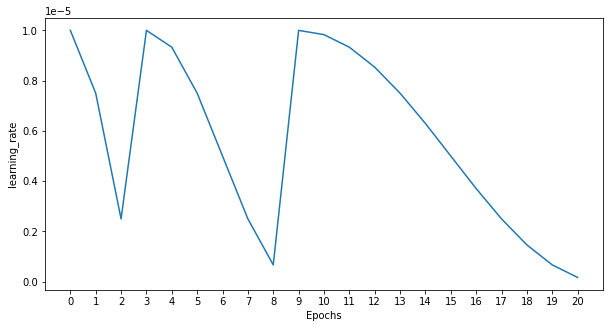

In [5]:
learning_rate = CosineDecayRestarts(
    initial_learning_rate=1e-5, 
    first_decay_steps=3,
    t_mul=2.0,
    m_mul=1.0,
    alpha=0.0)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

plt.figure(figsize=(10,5))
plt.plot(range(0,21), [optimizer.lr(epoch) for epoch in range(0,21)])
plt.xticks(range(0,21))
plt.xlabel("Epochs")
plt.ylabel("learning_rate")
plt.show()

In [20]:
def QAtraining(epochs):
    cce_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.2)
    model = QAModel(pretrained='bert-base-uncased', max_len=MAX_LEN)
    t_jaccard_metric = tf.keras.metrics.MeanIoU(num_classes=2)
    v_jaccard_metric = tf.keras.metrics.MeanIoU(num_classes=2)
    metrics = ['loss', 'jaccard', 'val_loss', 'val_jaccard']
    best_score = 0

    @tf.function
    def getArrays(array):
        start_array = tf.where(
            tf.sequence_mask(
                lengths=tf.math.argmax(array[0], axis=1), 
                maxlen=MAX_LEN), 
            x=1, y=0)
        end_array = tf.where(
            tf.sequence_mask(
                lengths=tf.math.argmax(array[1], axis=1),
                maxlen=MAX_LEN),
            x=1, y=0)
        return tf.abs(end_array - start_array)

    @tf.function
    def train_step(X, y, loss_fn):
        y = [y['output_1'], y['output_2']]
        with tf.GradientTape() as tape:        
            y_hat = model(X, training=True)
            loss_value = loss_fn(y, y_hat)
            loss_value += sum(model.losses)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        t_jaccard_metric.update_state(getArrays(y), getArrays(y_hat))
        return loss_value

    @tf.function
    def val_step(X, y, loss_fn):
        y = [y['output_1'], y['output_2']]
        y_hat = model(X, training=False)
        loss_value = loss_fn(y, y_hat)
        v_jaccard_metric.update_state(getArrays(y), getArrays(y_hat))
        return loss_value

    i = 0
    for epoch in range(1, epochs+1):
        print(f"Epoch {epoch}/{epochs}")
        progbar = Progbar(len(train_gen), interval=0.5, stateful_metrics=metrics)
        print(f"INFO -- Learning rate set to {optimizer.lr(epoch)}.")
        for step, (X_train, y_train) in enumerate(train_gen):
            train_loss = train_step(X_train, y_train, cce_fn)
            progbar.update(step, values=[('loss', train_loss), ('jaccard', t_jaccard_metric.result())])

        for x_batch_val, y_batch_val in val_gen:
            val_loss = val_step(x_batch_val, y_batch_val, cce_fn)

        values = [
            ('loss', train_loss), 
            ('jaccard', t_jaccard_metric.result()),
            ('val_loss', val_loss),
            ('val_jaccard', v_jaccard_metric.result())]
        progbar.update(len(train_gen), values=values, finalize=True)

        if best_score < v_jaccard_metric.result():
            best_score = v_jaccard_metric.result()
            save_path = f"models/phrase_model.h5"
            model.save_weights(save_path)
            print(f"INFO -- Model weights saved in {save_path}.\n")
            i = 0
        else:
            i += 1
            if i < 2:
                print("INFO -- Model did not improve.\n")
            else:
                print("INFO -- Early Stopping.\n")
                break

        t_jaccard_metric.reset_states()
        v_jaccard_metric.reset_states()



skf = StratifiedKFold(n_splits=args.splits, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(skf.split(
        X=train_data.drop('sentiment', axis=1),
        y=train_data['sentiment'])):

    train = train_data.loc[train_idx, :].reset_index(drop=True)
    val = train_data.loc[val_idx, :].reset_index(drop=True)

    train_gen = generator(df=train, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)
    val_gen = generator(df=val, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)
    
    QAModel = QAtraining(epochs=EPOCHS, train_gen=train_gen, val_gen=val_gen)

SyntaxError: positional argument follows keyword argument (<ipython-input-20-1b482023ee3a>, line 92)

In [7]:
# model.load_weights('models\phrase_model.h5')

In [8]:
# @tf.function
# def getArrays(array):
#     start_array = tf.where(
#         tf.sequence_mask(
#             lengths=tf.math.argmax(array[0], axis=1), 
#             maxlen=128), 
#         x=1, y=0)
#     end_array = tf.where(
#         tf.sequence_mask(
#             lengths=tf.math.argmax(array[1], axis=1),
#             maxlen=128),
#         x=1, y=0)
#     return tf.abs(end_array - start_array)

# batch = next(iter(val_gen))
# inputs = getArrays(model(batch[0], training=True))[0]
# outputs = getArrays([batch[1]['output_1'], batch[1]['output_2']])[0]
# print("inputs:", inputs)
# print("outputs:", outputs)
# jaccard = tf.keras.metrics.MeanIoU(num_classes=2)
# jaccard.update_state(inputs, outputs)
# print("jaccard:", jaccard.result().numpy())